In [1]:
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader, TensorDataset
from datasets import load_dataset
import pandas as pd
import torch


## Data

### Data loading

In [3]:
swda = load_dataset("swda")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/213543 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/56729 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4514 [00:00<?, ? examples/s]

Dataset swda downloaded and prepared to /root/.cache/huggingface/datasets/swda/default/0.0.0/b53d17ec4c6e31d0921591dd2d8e86d15850822209a980fcddb2983fc948e499. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

### Data cleaning

In [4]:
import re

def clean_swda_utterance(text):
    """
    This function takes a string of SWDA utterance text and returns a cleaned version of the text.
    """
    # Remove square brackets and anything inside them
    text = re.sub(r'\[.*?\]', '', text)
    
    # Remove leading and trailing whitespaces
    text = text.strip()
    
    # Remove any remaining parentheses and their contents
    text = re.sub(r'\(.*?\)', '', text)
    
    # Remove any remaining non-alphanumeric characters except for spaces
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Convert all letters to lowercase
    text = text.lower()
    
    # Remove any residual spaces
    text = ' '.join(text.split())
    
    return {"text": text}


In [5]:
swda = swda.map(lambda x : clean_swda_utterance(x['text']))


  0%|          | 0/213543 [00:00<?, ?ex/s]

  0%|          | 0/56729 [00:00<?, ?ex/s]

  0%|          | 0/4514 [00:00<?, ?ex/s]

In [6]:
# Define the data preprocessing function
def preprocess_data(utterance):
    text = utterance['text']
    speaker = utterance['caller']
    label = utterance['damsl_act_tag']

    return {'text': text, 'speaker': speaker, 'label': label}
# Preprocess the data
swda = swda.map(preprocess_data)

  0%|          | 0/213543 [00:00<?, ?ex/s]

  0%|          | 0/56729 [00:00<?, ?ex/s]

  0%|          | 0/4514 [00:00<?, ?ex/s]

In [7]:
swda.remove_columns(['swda_filename', 'ptb_basename', 'conversation_no', 'transcript_index', 'act_tag', 'damsl_act_tag', 'caller', 'utterance_index', 'subutterance_index','pos', 'trees', 'ptb_treenumbers', 'talk_day', 'length', 'topic_description', 'prompt', 'from_caller', 'from_caller_sex', 'from_caller_education', 'from_caller_birth_year', 'from_caller_dialect_area', 'to_caller', 'to_caller_sex', 'to_caller_education', 'to_caller_birth_year', 'to_caller_dialect_area'])

DatasetDict({
    train: Dataset({
        features: ['text', 'speaker', 'label'],
        num_rows: 213543
    })
    validation: Dataset({
        features: ['text', 'speaker', 'label'],
        num_rows: 56729
    })
    test: Dataset({
        features: ['text', 'speaker', 'label'],
        num_rows: 4514
    })
})

In [8]:
def map_speaker_to_int(data):
    """
    This function maps the speaker information in an example to 0 or 1.
    """
    # Get the caller information from the example
    caller = data["caller"]
    
    # Map the caller to 0 or 1
    if caller == "A":
        data["speaker"] = 0
    elif caller == "B":
        data["speaker"] = 1
    
    return data

In [9]:
swda = swda.map(map_speaker_to_int)

  0%|          | 0/213543 [00:00<?, ?ex/s]

  0%|          | 0/56729 [00:00<?, ?ex/s]

  0%|          | 0/4514 [00:00<?, ?ex/s]

In [10]:
train_dataset = pd.DataFrame(swda['train'])
val_dataset = pd.DataFrame(swda['validation'])

In [11]:
test_dataset = pd.DataFrame(swda['test'])
test_dataset = test_dataset[['conversation_no','speaker','text','damsl_act_tag']]

In [12]:
train_dataset = train_dataset[['conversation_no','speaker','text','damsl_act_tag']]
val_dataset = val_dataset[['conversation_no','speaker','text','damsl_act_tag']]


### Data Processing

In [13]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [14]:
def pre_process(data):
    
    # Create mapping of speaker IDs
    speakers = data["speaker"].unique()
    speaker_to_id = {speaker: i for i, speaker in enumerate(speakers)}

    # Group utterances by conversation ID
    conversations = data.groupby("conversation_no")
    

    # Create input sequences for each conversation
    inputs = []
    speakers_id = []
    da_labels_all = []
    for _, conversation in conversations:
        
        # Select conversation with more than 30 utterances
        if len(conversation["text"]) >= 30:

            # Tokenize text
            tokenized_text = [[tokenizer.encode(utterance)[:128] + [tokenizer.pad_token_id] * (128 - len(tokenizer.encode(utterance)[:128])) for utterance in conversation["text"][:30]]]

            # Add [SEP] tokens between utterances
            tokenized_text = [token for seq in tokenized_text for token in seq]

            # Convert speaker IDs
            speaker_ids = [speaker_to_id[speaker] for speaker in conversation["speaker"][:30]]

            # Convert DA labels
            da_labels = torch.tensor(conversation["damsl_act_tag"][:30].values)


            # Convert to PyTorch tensors and add to inputs list
            inputs.append(torch.tensor(tokenized_text))
            speakers_id.append(torch.tensor(speaker_ids))
            da_labels_all.append(da_labels)
            
         
        
    
    return torch.stack(inputs),  torch.stack(speakers_id), torch.stack(da_labels_all)


In [15]:
inputs, speakers, labels = pre_process(train_dataset)
val_inputs, val_speakers, val_labels = pre_process(val_dataset)

In [16]:
train_df = TensorDataset(inputs, speakers, labels)
val_df = TensorDataset(val_inputs, val_speakers, val_labels)

In [17]:
bert_model = BertModel.from_pretrained('bert-base-uncased')

train_loader = DataLoader(train_df, batch_size=4, shuffle=True)
val_loader = DataLoader(val_df, batch_size=4, shuffle=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
import gc
torch.cuda.empty_cache()
gc.collect()

322

In [21]:
!nvidia-smi

Fri Mar 17 15:04:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Bi-LSTM_cls Model with speaker

### Model definition

In [26]:
import torch
from transformers import BertModel

class SpeakerTurnDialogueActClassifier(torch.nn.Module):
    def __init__(self, bert_model, num_speakers, num_labels):
        super(SpeakerTurnDialogueActClassifier, self).__init__()
        
        self.bert = bert_model
        
        self.speaker_embedding = torch.nn.Embedding(num_speakers, 768)
                
        self.lstm = torch.nn.LSTM(input_size=768, hidden_size=256, num_layers=2, bidirectional=True, batch_first=True)
                
        self.fc = torch.nn.Linear(512, num_labels)
    
    def forward(self, input_ids, speaker_ids):
        
        # shape (batch_size, max_num_utterances, max_seq_length)
        batch_size, max_num_utterances, max_seq_length = input_ids.size()
        
        input_ids = input_ids.view(-1, max_seq_length)

        # empty list to store the output of each chunk
        outputs = []

        if batch_size < 2:
            chunk_size = 1
        else:
            chunk_size = batch_size//2
        #loop through the input_ids and attention_mask tensors by chunk_size
        for i in range(0, len(input_ids), chunk_size):
            input_ids_chunk = input_ids[i:i+chunk_size]
            bert_output = self.bert(input_ids=input_ids_chunk)[0][:,0]
            outputs.append(bert_output)

        # Concatenate the outputs of each chunk
        bert_output = torch.cat(outputs, dim=0)

        # reshape to (batch_size* max_num_utterances, 768)
        bert_output = bert_output.view(batch_size* max_num_utterances, -1)

        # reshape to (batch_size * max_num_utterances)
        speaker_ids = speaker_ids.reshape(-1)
        speaker_embeddings = self.speaker_embedding(speaker_ids.to(input_ids.device))
        speaker_embeddings = speaker_embeddings # shape (batch_size * max_num_utterances, 768)


        # add speaker embeddings
        encoder_inputs = bert_output + speaker_embeddings # shape (batch_size * max_num_utterances, 768)

        encoder_inputs = encoder_inputs.reshape(batch_size,max_num_utterances,-1)

        lstm_output, _ = self.lstm(encoder_inputs) # shape (batch_size, max_num_utterances, 512)
        
        logits = self.fc(lstm_output) 
        
        logits = logits.view(batch_size, max_num_utterances, -1) # shape (batch_size, max_num_utterances, num_labels)
        return logits


In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Initialization

In [27]:
import torch.optim as optim

# define hyperparameters
num_epochs = 10
learning_rate = 1e-4
num_labels = 43 

# initialize the model and optimizer
model = SpeakerTurnDialogueActClassifier(bert_model = bert_model, num_speakers=2, num_labels=num_labels)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# define the loss function
criterion = torch.nn.CrossEntropyLoss().to(device)

### Training

In [28]:
# create an empty dataframe to store the loss and accuracy values
results_df = pd.DataFrame(columns=['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy'])

# start the training loop
for epoch in range(num_epochs):
    # train the model
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for i, (input_ids, speaker_ids, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        input_ids = input_ids.to(device)
        labels = labels.to(device)
        speaker_ids= speaker_ids.to(device)
        logits = model(input_ids, speaker_ids)
        logits = logits.view(-1, num_labels) # shape (batch_size * num_utterances, num_labels)
        labels = labels.view(-1) # shape (batch_size * num_utterances,)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        if (i+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Train Loss: {loss.item():.4f}')
    
    # compute the average train loss and accuracy for the entire epoch
    train_accuracy = 100 * train_correct / train_total
    train_loss = train_loss / len(train_loader.dataset)
    print('[%d] training loss: %.3f, training accuracy: %.3f%%' %
          (epoch + 1, train_loss, train_accuracy))
    
    # save the train loss and accuracy after each epoch
    results_df = results_df.append({'epoch': epoch+1, 
                                    'train_loss': train_loss,
                                    'train_accuracy': train_accuracy,
                                    'val_loss': None,
                                    'val_accuracy': None}, ignore_index=True)
    
    # evaluate the model on the validation set
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for input_ids, speaker_ids, labels in val_loader:
            input_ids = input_ids.to(device)
            labels = labels.to(device)
            speaker_ids= speaker_ids.to(device)
            logits = model(input_ids, speaker_ids)
            logits = logits.view(-1, num_labels)
            labels = labels.view(-1)
            loss = criterion(logits, labels)
            val_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_accuracy = 100 * val_correct / val_total
    val_loss = val_loss / len(val_loader.dataset)
    print('[%d] validation loss: %.3f, validation accuracy: %.3f%%' %
          (epoch + 1, val_loss, val_accuracy))
    
    # save the val loss and accuracy after each epoch
    results_df.loc[results_df.epoch == epoch+1, 'val_loss'] = val_loss
    results_df.loc[results_df.epoch == epoch+1, 'val_accuracy'] = val_accuracy


Epoch [1/10], Step [10/279], Train Loss: 2.9585
Epoch [1/10], Step [20/279], Train Loss: 2.6194
Epoch [1/10], Step [30/279], Train Loss: 2.4518
Epoch [1/10], Step [40/279], Train Loss: 2.2613
Epoch [1/10], Step [50/279], Train Loss: 2.6990
Epoch [1/10], Step [60/279], Train Loss: 2.1311
Epoch [1/10], Step [70/279], Train Loss: 1.8656
Epoch [1/10], Step [80/279], Train Loss: 2.4470
Epoch [1/10], Step [90/279], Train Loss: 2.5842
Epoch [1/10], Step [100/279], Train Loss: 2.1268
Epoch [1/10], Step [110/279], Train Loss: 2.1650
Epoch [1/10], Step [120/279], Train Loss: 1.8904
Epoch [1/10], Step [130/279], Train Loss: 2.1494
Epoch [1/10], Step [140/279], Train Loss: 2.0413
Epoch [1/10], Step [150/279], Train Loss: 1.8039
Epoch [1/10], Step [160/279], Train Loss: 1.9849
Epoch [1/10], Step [170/279], Train Loss: 1.6313
Epoch [1/10], Step [180/279], Train Loss: 1.9796
Epoch [1/10], Step [190/279], Train Loss: 1.9119
Epoch [1/10], Step [200/279], Train Loss: 2.3035
Epoch [1/10], Step [210/279],

KeyboardInterrupt: 

#### Evaluation

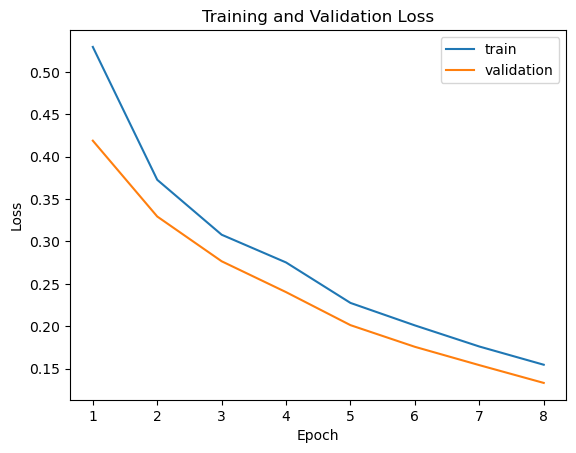

In [29]:
import matplotlib.pyplot as plt

# plot train and validation losses
plt.plot(results_df.epoch, results_df.train_loss, label='train')
plt.plot(results_df.epoch, results_df.val_loss, label='validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

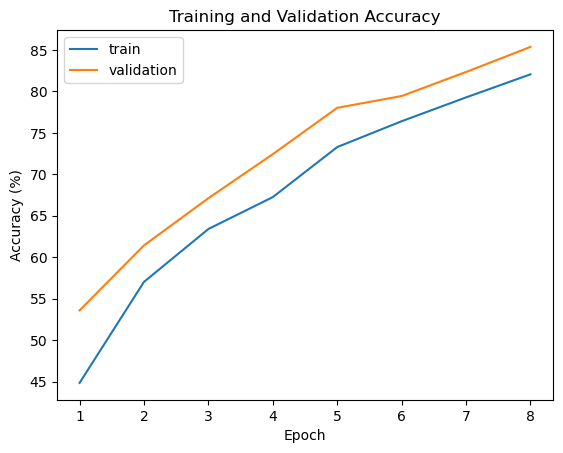

In [30]:

# plot train and validation accuracies
plt.plot(results_df.epoch, results_df.train_accuracy, label='train')
plt.plot(results_df.epoch, results_df.val_accuracy, label='validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


### Model Saving

In [31]:
torch.save(model.state_dict(), 'speaker_cls_lstm_model.pt')

#### Inference

In [32]:
test_input, test_speakers, test_labels = pre_process(test_dataset)
test_df = TensorDataset(test_input, test_speakers, test_labels)

test_loader = DataLoader(train_df, batch_size=2, shuffle=True)

In [33]:
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
    all_predicted_labels = []
    all_true_labels = []
    for input_ids, speaker_ids, labels in test_loader:
        input_ids = input_ids.to(device)
        speaker_ids =  speaker_ids.to(device)
        labels = labels.to(device)
        logits = model(input_ids, speaker_ids)
        logits = logits.view(-1, num_labels)
        labels = labels.view(-1)
        loss = criterion(logits, labels)
        test_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        
        all_predicted_labels.extend(predicted.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())
        
test_accuracy = 100 * test_correct / test_total
test_loss = test_loss / len(test_loader.dataset)
print('[%d] test loss: %.3f, test accuracy: %.3f%%' %
      (epoch + 1, test_loss, test_accuracy))

[9] test loss: 0.256, test accuracy: 85.465%


In [35]:
from sklearn.metrics import precision_recall_fscore_support

In [36]:
# Calculate precision, recall, F1-score, and support
precision, recall, f1_score, support = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='weighted',zero_division=1)
# Create a DataFrame with the metrics
metrics_data = { 'Weighted Avg Precision': [precision],
                'Weighted Avg Recall': [recall],
                'Weighted Avg F1-score': [f1_score]
               }
metrics_df = pd.DataFrame(metrics_data)

# Display the metrics DataFrame
print(metrics_df)

   Weighted Avg Precision  Weighted Avg Recall  Weighted Avg F1-score
0                0.851033             0.854649               0.839771


# Bi-LSTM_avg model

### Model definition

In [18]:
import torch
from transformers import BertModel

class BaseDialogueActClassifier(torch.nn.Module):
    def __init__(self, bert_model, num_labels):
        super(BaseDialogueActClassifier, self).__init__()
        
        self.bert = bert_model
                
        self.lstm = torch.nn.LSTM(input_size=768, hidden_size=256, num_layers=2, bidirectional=True, batch_first=True)
                
        self.fc = torch.nn.Linear(512, num_labels)
    
    def forward(self, input_ids):
        
        # input_ids and attention_mask have shape (batch_size, max_num_utterances, max_seq_length)
        batch_size, max_num_utterances, max_seq_length = input_ids.size()
        
        input_ids = input_ids.view(-1, max_seq_length) # shape (batch_size * max_num_utterances, max_seq_length)
        
        bert_output = self.bert(input_ids=input_ids)[0] # shape (batch_size * max_num_utterances, max_seq_length, 768)
        
        lstm_output, _ = self.lstm(bert_output) # shape (batch_size * max_num_utterances, max_seq_length, 512)
                
        pooled_output = lstm_output.mean(dim=1)  # shape (batch_size * max_num_utterances, 512)
        
        logits = self.fc(pooled_output) # shape (batch_size * max_num_utterances, num_labels)
        
        logits = logits.view(batch_size, max_num_utterances, -1) # shape (batch_size, max_num_utterances, num_labels)
        return logits



In [27]:
import torch.optim as optim

# define hyperparameters
num_epochs = 10
learning_rate = 1e-4
num_labels = 43 

# initialize the model and optimizer
model_2 = BaseDialogueActClassifier(bert_model = bert_model, num_labels=num_labels)
model_2.to(device)
optimizer = optim.Adam(model_2.parameters(), lr=learning_rate)

# define the loss function
criterion = torch.nn.CrossEntropyLoss().to(device)

In [28]:
# create an empty dataframe to store the loss and accuracy values
base_results_df = pd.DataFrame(columns=['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy'])

# start the training loop
for epoch in range(num_epochs):
    # train the model
    model_2.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for i, (input_ids, _ , labels) in enumerate(train_loader):
        optimizer.zero_grad()
        input_ids = input_ids.to(device)
        labels = labels.to(device)
        logits = model_2(input_ids)
        logits = logits.view(-1, num_labels) # shape (batch_size * num_utterances, num_labels)
        labels = labels.view(-1) # shape (batch_size * num_utterances,)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        if (i+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Train Loss: {loss.item():.4f}')
    
    # compute the average train loss and accuracy for the entire epoch
    train_accuracy = 100 * train_correct / train_total
    train_loss = train_loss / len(train_loader.dataset)
    print('[%d] training loss: %.3f, training accuracy: %.3f%%' %
          (epoch + 1, train_loss, train_accuracy))
    
    # save the train loss and accuracy after each epoch
    base_results_df = base_results_df.append({'epoch': epoch+1, 
                                    'train_loss': train_loss,
                                    'train_accuracy': train_accuracy,
                                    'val_loss': None,
                                    'val_accuracy': None}, ignore_index=True)
    
    # evaluate the model on the validation set
    model_2.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for input_ids, _, labels in val_loader:
            input_ids = input_ids.to(device)
            labels = labels.to(device)
            logits = model_2(input_ids)
            logits = logits.view(-1, num_labels)
            labels = labels.view(-1)
            loss = criterion(logits, labels)
            val_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_accuracy = 100 * val_correct / val_total
    val_loss = val_loss / len(val_loader.dataset)
    print('[%d] validation loss: %.3f, validation accuracy: %.3f%%' %
          (epoch + 1, val_loss, val_accuracy))
    
    # save the val loss and accuracy after each epoch
    base_results_df.loc[base_results_df.epoch == epoch+1, 'val_loss'] = val_loss
    base_results_df.loc[base_results_df.epoch == epoch+1, 'val_accuracy'] = val_accuracy

Epoch [1/10], Step [10/279], Train Loss: 2.8803
Epoch [1/10], Step [20/279], Train Loss: 2.1759
Epoch [1/10], Step [30/279], Train Loss: 1.6957
Epoch [1/10], Step [40/279], Train Loss: 1.5460
Epoch [1/10], Step [50/279], Train Loss: 1.4100
Epoch [1/10], Step [60/279], Train Loss: 1.4565
Epoch [1/10], Step [70/279], Train Loss: 1.5650
Epoch [1/10], Step [80/279], Train Loss: 1.2281
Epoch [1/10], Step [90/279], Train Loss: 1.1226
Epoch [1/10], Step [100/279], Train Loss: 1.1726
Epoch [1/10], Step [110/279], Train Loss: 1.2014
Epoch [1/10], Step [120/279], Train Loss: 1.6221
Epoch [1/10], Step [130/279], Train Loss: 1.1010
Epoch [1/10], Step [140/279], Train Loss: 1.3224
Epoch [1/10], Step [150/279], Train Loss: 1.9464
Epoch [1/10], Step [160/279], Train Loss: 1.4836
Epoch [1/10], Step [170/279], Train Loss: 0.8342
Epoch [1/10], Step [180/279], Train Loss: 1.2440
Epoch [1/10], Step [190/279], Train Loss: 1.5241
Epoch [1/10], Step [200/279], Train Loss: 1.1370
Epoch [1/10], Step [210/279],

### Evaluation

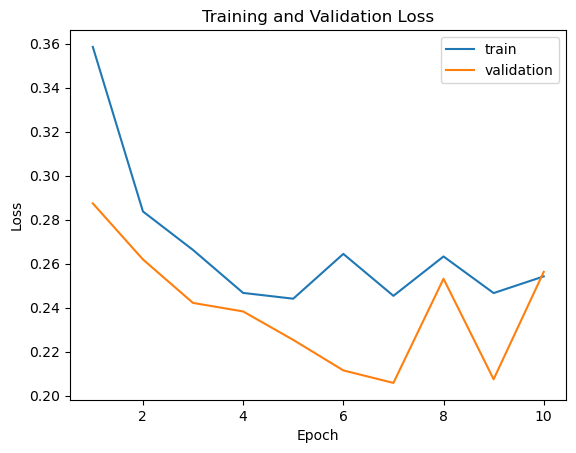

In [29]:
# plot train and validation losses
import matplotlib.pyplot as plt


plt.plot(base_results_df.epoch, base_results_df.train_loss, label='train')
plt.plot(base_results_df.epoch, base_results_df.val_loss, label='validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

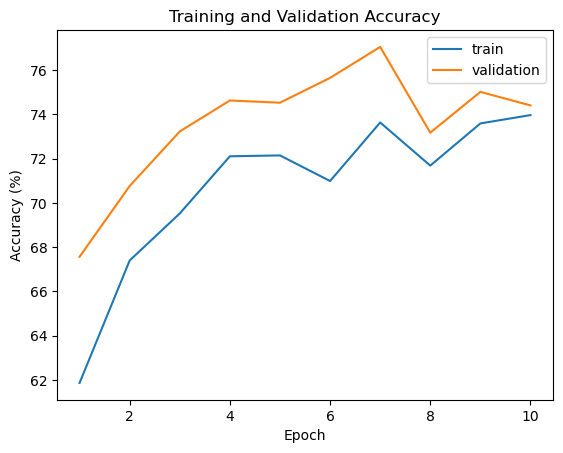

In [30]:

# plot train and validation accuracies
plt.plot(base_results_df.epoch, base_results_df.train_accuracy, label='train')
plt.plot(base_results_df.epoch, base_results_df.val_accuracy, label='validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


In [31]:
torch.save(model_2.state_dict(), 'avg_lstm_model.pt')

### Inference

In [58]:
model_2.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
    for input_ids, _, labels in test_loader:
        input_ids = input_ids.to(device)
        labels = labels.to(device)
        logits = model_2(input_ids)
        logits = logits.view(-1, num_labels)
        labels = labels.view(-1)
        loss = criterion(logits, labels)
        test_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
test_accuracy = 100 * test_correct / test_total
test_loss = test_loss / len(test_loader.dataset)
print('[%d] test loss: %.3f, test accuracy: %.3f%%' %
      (epoch + 1, test_loss, test_accuracy))

# save the test loss and accuracy after each epoch
base_results_df = base_results_df.append({'epoch': epoch+1, 
                                'train_loss': None,
                                'train_accuracy': None,
                                'val_loss': None,
                                'val_accuracy': None,
                                'test_loss': test_loss,
                                'test_accuracy': test_accuracy}, ignore_index=True)


[10] test loss: 0.506, test accuracy: 74.610%


In [56]:

model_2.eval()
with torch.no_grad():
    all_predicted_labels = []
    all_true_labels = []
    for input_ids, _, labels in test_loader:
        input_ids = input_ids.to(device)
        labels = labels.to(device)
        logits = model_2(input_ids)
        logits = logits.view(-1, num_labels)
        labels = labels.view(-1)
        _, predicted = torch.max(logits, 1)
        all_predicted_labels.extend(predicted.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())


In [57]:
# Calculate precision, recall, F1-score, and support
precision, recall, f1_score, support = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='weighted',zero_division=1)
# Create a DataFrame with the metrics
metrics_data = { 'Weighted Avg Precision': [precision],
                'Weighted Avg Recall': [recall],
                'Weighted Avg F1-score': [f1_score]
               }
metrics_df = pd.DataFrame(metrics_data)

# Display the metrics DataFrame
print(metrics_df)

   Weighted Avg Precision  Weighted Avg Recall  Weighted Avg F1-score
0                0.757491             0.746099               0.716529
